In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

In [2]:
# Physical Parameters
f = 1
N0 = 1

# Numerics Parameters
Lz = 2*np.pi
Nz = 128

dtype = np.float64

# Bases
Lzt, Lzb = 0, -Lz

coords = d3.CartesianCoordinates('z')
dist = d3.Distributor(coords, dtype=dtype)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(Lzb, Lzt))

In [3]:
# Fields
N2 = dist.Field(bases=zbasis)

# Substitutions
dz = lambda A: d3.Differentiate(A, coords['z'])

In [4]:
# Fields
lamb2 = dist.Field()

psi = dist.Field(bases=zbasis )

# tau_psi = dist.Field()
tau_psit = dist.Field( )
tau_psib = dist.Field( )

z = dist.local_grids(zbasis)

lift_basis = zbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

In [5]:
# N2['g'] = N0**2*1
N2['g'] = N0**2*np.exp(z)

# Problem
problem = d3.EVP([psi, tau_psit, tau_psib], eigenvalue=lamb2, namespace=locals())

problem.add_equation("dz( (f**2/N2)*dz(psi) ) + lift(tau_psit,-1) + lift(tau_psib,-2) + lamb2*psi = 0")
problem.add_equation("dz(psi)(z=Lzt) = 0"); problem.add_equation("dz(psi)(z=Lzb) = 0")


{'LHS': interp(Diff(<Field 140406332787888>), z=-6.283185307179586),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': interp(Diff(<Field 140406332787888>), z=-6.283185307179586),
 'domain': <dedalus.core.domain.Domain at 0x7fb31d58fe30>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [6]:
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
evals = solver.eigenvalues

2024-04-15 14:56:24,224 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


In [7]:
# evals

In [8]:
smallest_idx = np.argsort(evals.real)[:4]

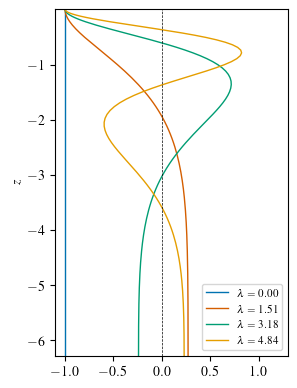

In [13]:
fig=plt.figure(figsize=(3,4.5))

for i in smallest_idx:
    # print(evals[i])
    solver.set_state(i,0)
    psi_evec = solver.state[0]['g']
    psi_evec /= np.max(np.abs(psi_evec))

    plt.plot(psi_evec,z[0].ravel(),label=r"$\lambda=%.2f$" %np.real(evals[i]**0.5))

plt.axvline(0,color='k',linewidth=0.5,linestyle='--')
plt.xlim(-1.1,1.3)
plt.legend()
plt.ylabel("$z$")

plt.savefig("figs/expo_strat_mode.png", bbox_inches='tight', dpi=400)
plt.show()